In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import pickle

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.learning_curve import learning_curve
from sklearn.model_selection import train_test_split

from sklearn.cluster import MiniBatchKMeans

import xgboost as xgb

/Users/PandaGongfu/anaconda/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/PandaGongfu/anaconda/lib/python3.5/site-packages/sklearn/learning_curve.py:23: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the functions are moved. This module will be removed in 0.20
  DeprecationWarning)


In [3]:
texting_features = pickle.load(open('data/texting.pickle', 'rb'))
driving_features = pickle.load(open('data/driving.pickle', 'rb'))
all_features = texting_features + driving_features
labels = ['texting']*len(texting_features) + ['driving']*len(driving_features)

In [30]:
def train_test_val_split_ids(m, test_size=0.2):
    test_m = round(m*test_size)
    training_ids = np.random.choice(m, m-test_m, replace=False)
    test_ids = np.array(list(set(range(m)) - set(training_ids)))
    return training_ids, test_ids
N_Clusters = 10
cluster_model = MiniBatchKMeans(n_clusters=N_Clusters)

training_ids, test_ids = train_test_val_split_ids(len(labels), test_size=0.3)
training_features = [all_features[t_id] for t_id in training_ids]

training_features_unstacked = np.vstack(training_features)
cluster_model.fit(training_features_unstacked)

bow = [cluster_model.predict(sift_feature) for sift_feature in all_features]
bow_hist = np.array(
    [np.bincount(code_words, minlength=N_Clusters) for code_words in bow])


In [33]:
X = bow_hist
y = np.array(labels)

X_train = X[training_ids, :]
X_test = X[test_ids, :]
y_train = y[training_ids]
y_test = y[test_ids]

nb = GaussianNB()
svc = SVC(probability=True)
rfc = RandomForestClassifier()
logit = LogisticRegression()
gbtr = GradientBoostingClassifier()
gbm = xgb.XGBClassifier(max_depth=5, n_estimators=500, learning_rate=0.1)

model_names = ['Naive Bayes', 'SVM', 'Random Forest', 'Logistic', 'GBboost','XGBoost']
models = [nb, svc, rfc, logit, gbtr, gbm]
for name, model in zip(model_names, models):
    model.fit(X_train, y_train)

    print(name)
    print('Accuracy: %6.4f' % accuracy_score(model.predict(X_test), y_test))
    print(classification_report(y_test, model.predict(X_test)))

Naive Bayes
Accuracy: 0.7200
             precision    recall  f1-score   support

    driving       0.90      0.41      0.56        22
    texting       0.68      0.96      0.79        28

avg / total       0.77      0.72      0.69        50

SVM
Accuracy: 0.4400
             precision    recall  f1-score   support

    driving       0.44      1.00      0.61        22
    texting       0.00      0.00      0.00        28

avg / total       0.19      0.44      0.27        50

Random Forest
Accuracy: 0.6200
             precision    recall  f1-score   support

    driving       0.55      0.73      0.63        22
    texting       0.71      0.54      0.61        28

avg / total       0.64      0.62      0.62        50

Logistic
Accuracy: 0.6200
             precision    recall  f1-score   support

    driving       0.55      0.73      0.63        22
    texting       0.71      0.54      0.61        28

avg / total       0.64      0.62      0.62        50

GBboost
Accuracy: 0.5600
        

/Users/PandaGongfu/anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


XGBoost
Accuracy: 0.7000
             precision    recall  f1-score   support

    driving       0.65      0.68      0.67        22
    texting       0.74      0.71      0.73        28

avg / total       0.70      0.70      0.70        50



In [ ]:
def convert_y(y_str):
    return 1 if y_str=='texting' else 0

y_test = list(map(convert_y, y_test))
y_train = list(map(convert_y, y_train))

AUC Score
Naive Bayes: 0.7143
Random Forest: 0.7427
Logistic: 0.6932
XGBoost: 0.7484


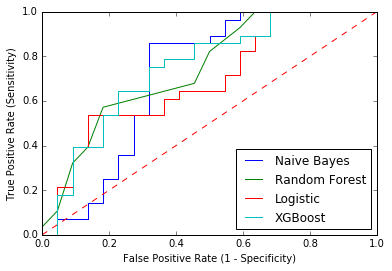

In [58]:
def plot_ROC_curve(models, model_names, X_train, y_train, X_test, y_test):

    print('AUC Score')
    for name, model in zip(model_names, models):
        model.fit(X_train, y_train)
        pred_probs = model.predict_proba(X_test)

        fpr, tpr, thresholds = roc_curve(y_test, pred_probs[:, 1])
        plt.plot(fpr, tpr, label=name);
        plt.legend(loc='best');
        print(name + ': %6.4f' % roc_auc_score(y_test, pred_probs[:, 1]))
    plt.plot(fpr, fpr, 'r--');
    plt.xlabel("False Positive Rate (1 - Specificity)");
    plt.ylabel("True Positive Rate (Sensitivity)");

nb = GaussianNB()
rfc = RandomForestClassifier()
logit = LogisticRegression()
gbm = xgb.XGBClassifier(max_depth=5, n_estimators=500, learning_rate=0.1)

model_names = ['Naive Bayes', 'Random Forest', 'Logistic', 'XGBoost']
models = [nb, rfc, logit, gbm]

plot_ROC_curve(models, model_names, X_train, y_train, X_test, y_test)